# **Projet Machine Learning**

*BOGUSLAWSKI Eva - CANAL Audrey - SANTARSIERI Giulia* 

*ISDS - Alternantes - 2020/2021*


**Contexte**

En tant qu'étudiantes nous sommes amenées à consommer de la musique sur plusieurs plateformes de streaming, notamment Spotify, et cela tous les jours et dans différents cadres. Cependant, il n'est pas toujours aisé de trouver de nouvelles playlists ou hits à notre goût. En effet, si on se rend dans l'onglet populaire il est fort probable que tout ne nous plaise pas. Quels facteurs musicaux influencent sur la popularité d'une musique ? Comment peut on prédire la popularité ? 

Ainsi, en tombant sur cette base de données Kaggle, nous nous sommes tout de suite senties inspirées par le sujet. Nous avons aussi vu l'opportunité de réaliser différentes tâches comme de la regression pour prédire la popularité d'un titre, de la classification pour retrouver la prériode de sortie d'une chanson (en fonction des caractéristiques musicales) ou encore son genre musicale, pour en citer quelques uns.

Ce data set venant de https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks a été extrait de Spotify grâce aux outils requêtes de Spotify dans leur "data collection". Cette base de données *data.csv* contient 170 000 chansons et 19 variables.

**Objectifs**

* Prédire la popularité des musiques
* Classer les musiques selon leur décennie 

**Méthodes**

Pour atteindre nos deux objectifs nous allons tester plusieurs modèles.

Pour ce qui est de la régression sur la popularité, nous allons explorer :
* Les méthodes d'arbres : arbre de décision, RandomForest, extraTrees, adaboost
* Les méthodes SVR (on testera plusieurs variantes pour le noyau : gaussien et linéaire) et Kernel Ridge Regression

Quant à la classification par décennie, nous allons implémenter :
* Un arbre RandomForest
* Les méthode LDA/QDA
* Une régression logistique
* La méthode Naive Bayes
* L'algorithme des k plus proches voisins (k-NN) 
* Des réseaux de neurones

Nous aurons deux enjeux importants tout au long du projet : la sélection de nos variables et l'optimisation de nos hyperparamètres.

On aurait pu tester d'autres types d'algorithmes et d'autres variantes mais nous avons dû faire des choix.

**Démarche**

On va d'abord diviser notre échantillon en 3 parties : Train - Validation - Test avec une séparation 60%-20%-20%. On effectuera nos sélections de variables (quand il y a besoin) et nos choix d'hyperparamètres par cross-validation sur l'échantillon Train, puis on comparera les résultats de chaque type d'algorithme (précédemment entrainé sur le train) sur l'échantillon de validation. Ceci va nous permettre de choisir un unique modèle final. On utilisera ces résultats sur l'échantillon de test pour fournir la précision finale obtenue.

Dans les cas où nous procédons à une sélection de variables, on commencera par faire une première pré-optimisation des hyperparamètres grossières. En effet, le but est d'avoir un modèle un peu adapté aux données. L'algorithme `RFECV` nous permettra de choisir nos variables. Ensuite on fera une optimisation des hyperparamètres plus poussée pour obtenir un modèle "final".

De plus, concernant le choix des plages de recherche des hyperparamètres, nous les avons choisies selon notre expérience en stage et alternance, grâce à diverses documentations sur internet et nos possibilités de calcul.

Il est à noter aussi que notre échantillon étant important, nous devons tenir compte de contraintes machine qui limitent notre puissance de calcul.


**Packages utiles**

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error, explained_variance_score
# models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR, LinearSVR
from sklearn.kernel_ridge import KernelRidge

## 1. Etudes préliminaires :

### 1.1 Importation des données :

In [4]:
path = "data_spotify/data.csv"
data = pd.read_csv(path)
data.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665


Nous disposons des variables suivantes transmises par Spotify :
* *valence* : indicateur entre 0 et 1 qui reflète la positivité de la musique
* *year* : l'année de sortie de la musique
* *acousticness* : cette valeur entre 0 et 1 décrit l'acoustique d'un morceau. Elle est proche de 1 si le morceau est très acoustique
* *artists* : les auteurs la chanson
* *danceability* : indicateur évoluant selon que la chanson se prête à danser ou non
* *duration_ms* : durée de la chanson en ms
* *energy* : indicateur représentant une perception générale de l'intensité de la chanson
* *explicit* : vaut 1 si la chanson est "explicit" et 0 sinon
* *id* : identifiant de la chanson
* *instrumentalness* : score entre 0 et 1 représentant l'instrumentalité de la chanson. Plus il est proche de 1 moins il y a de paroles. C'est l'opposé de la variable speechiness.
* *key* : tonalité sans prendre en compte le mode (si bémol, sol, ...)
* *liveness* : la probabilité que la chanson ait été enregistrée en direct
* *mode* : majeur ou mineur
* *name* : nom de la chanson
* *release_date* : date plus ou moins précise de sortie de la musique
* *speechiness* : indicateur sur la quantité de paroles dans la chanson
* *tempo* : le tempo de la chanson
* *popularity* : note sur 100 donnée par les utilisateurs

Spotify n'a pas beaucoup communiqué sur la façon dont il calcule ces indices. On va devoir lui faire confiance pour ce qui est de la cohérence de ces indicateurs. Ils semblent reposer sur des paramètres musicaux calculés par analyse musicale.


Nous avons décidé d'enlever d'ores et déjà quelques variables : 
* *id* car cela ne nous sera d'aucune utilité pour expliquer la popularité ou les décennies ;
* *release_date* car nous n'avons besoin que de l'année pour l'objectif qu'on s'est fixé. De plus, comme ces dates ne sont pas uniformisées (certaines n'ont que l'année, d'autres le mois et le jour), il est difficile de pouvoir l'utiliser.
* *name* et *artiste* car ce sont des variables qualitatives avec trop de levels pour pouvoir espérer faire du `one hot encoding`.



In [6]:
data.drop(columns=['id', 'release_date','name', 'artists'], inplace=True)

### 1.2 Premières statistiques :

Regardons quelques statistiques :

In [ ]:
data.describe()

,valence,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
count,170653.000000,170653.000000,170653.000000,170653.000000,1.706530e+05,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000
mean,0.528587,1976.787241,0.502115,0.537396,2.309483e+05,0.482389,0.084575,0.167010,5.199844,0.205839,-11.467990,0.706902,31.431794,0.098393,116.861590
std,0.263171,25.917853,0.376032,0.176138,1.261184e+05,0.267646,0.278249,0.313475,3.515094,0.174805,5.697943,0.455184,21.826615,0.162740,30.708533
min,0.000000,1921.000000,0.000000,0.000000,5.108000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000
25%,0.317000,1956.000000,0.102000,0.415000,1.698270e+05,0.255000,0.000000,0.000000,2.000000,0.098800,-14.615000,0.000000,11.000000,0.034900,93.421000
50%,0.540000,1977.000000,0.516000,0.548000,2.074670e+05,0.471000,0.000000,0.000216,5.000000,0.136000,-10.580000,1.000000,33.000000,0.045000,114.729000
75%,0.747000,1999.000000,0.893000,0.668000,2.624000e+05,0.703000,0.000000,0.102000,8.000000,0.261000,-7.183000,1.000000,48.000000,0.075600,135.537000
max,1.000000,2020.000000,0.996000,0.988000,5.403500e+06,1.000000,1.000000,1.000000,11.000000,1.000000,3.855000,1.000000,100.000000,0.970000,243.507000


Les variables n'ayant pas le même ordre de grandeur il sera important de faire du scaling.


Nous devons regarder aussi si notre jeu de données est "propre" : il y a t-il des valeurs manquantes ?

In [ ]:
data.isna().sum() 

valence             0
year                0
acousticness        0
danceability        0
duration_ms         0
energy              0
explicit            0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
popularity          0
speechiness         0
tempo               0
dtype: int64

Il n'y a pas de valeurs manquantes dans notre base de données !

Regardons les histogrammes pour chaque variable :

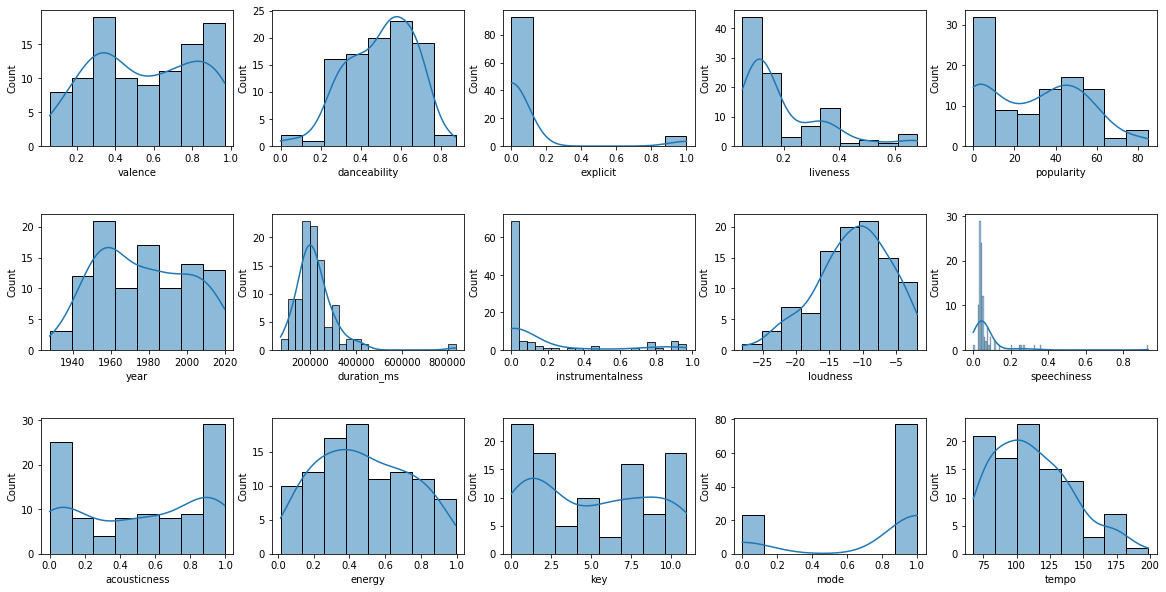

In [ ]:
fig, axs = plt.subplots(3, 5,figsize=(20,10))
plt.subplots_adjust(hspace=0.5)

for i,col in enumerate(data.columns):
  sns.histplot(data.sample(100), x=col, kde=True, ax=axs[i%3,i//3])

On s'aperçoit que les variables ont des distributions très variées et parmi ces distributions on ne distingue pas de lois connues de manière évidente. L'observation des histogrammes nous pousse à faire l'hypothèse que deux sous-populations pourraient être présentes parmi nos données.

Regardons maintenant les corrélations :

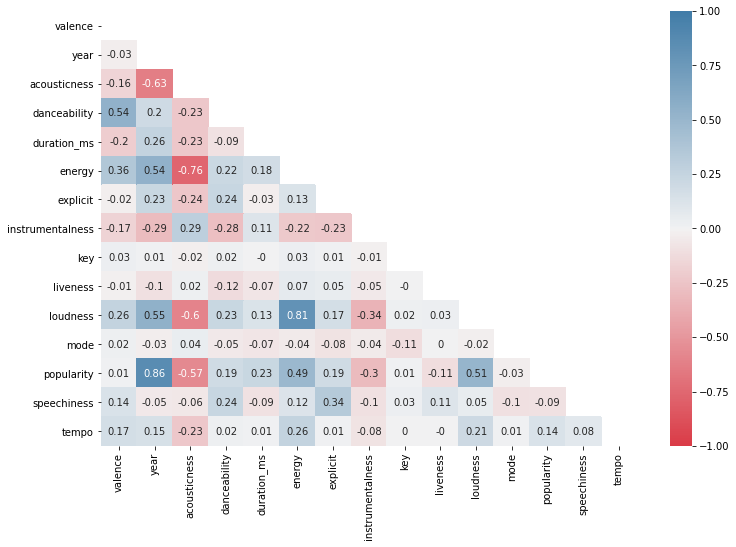

In [ ]:
corr = data.corr('spearman')
plt.figure(figsize=(12,8))
sns.heatmap(round(corr,2), annot=True, cmap = sns.diverging_palette(10, 240, as_cmap=True), 
            center=0, mask = np.triu(np.ones_like(corr, dtype=bool)), vmin=-1, vmax=1)

La variable *popularity* qui sera l'objet de notre prédiction de regression  est fortement correlée positivement à *year* et négativement corrélée à *acoustisticness*. D'autres variables telles que *loudness* ont également une corrélation avec *popularity*. 

On s'intéresse plus précisément aux nuages de points des variables corrélées avec *popularity*.

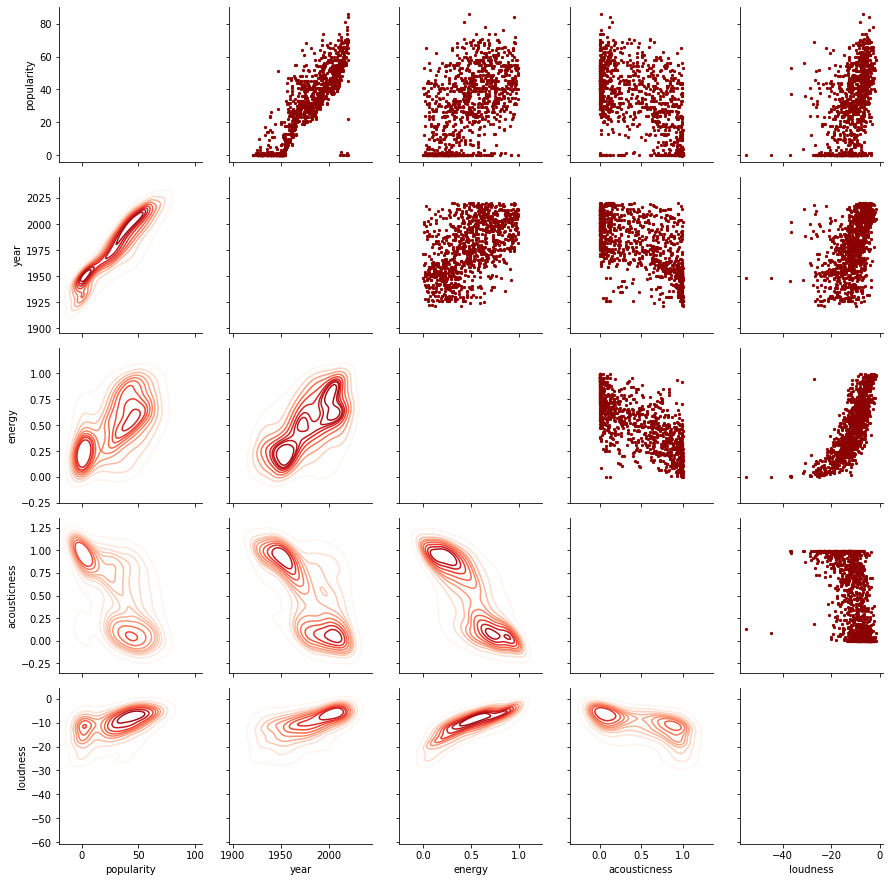

In [ ]:
sns.PairGrid(data= data.sample(1000), vars=['popularity', 'year', 'energy', 'acousticness', 'loudness'])\
.map_upper(plt.scatter, color = 'darkred', s=5).map_lower(sns.kdeplot, cmap = 'Reds')

Nous confirmons la très forte corrélation entre *year* et *popularity*, nous observons une tendance linéaire croissante. Les isodensités estimées nous ramènent à l'hypothèse que nous avions formulée : il y a peut-être deux sous-populations dans nos données.

### 1.3 Fonction générique pour la sélection d'hyperparamètres et de variables :

Nous avons implémenté deux fonctions qui seront utilisées tout au long du code :

In [ ]:
def pre_modelling(clf, pre_params_dict, X_train, y_train) :
    """Retourne une grossière optimisation des hyperparamètres
    (but faire de la sélection de variables ensuite donc on a pas besoin d'un modèle parfait 
    mais simplement d'un modèle cohérent avec nos données)"""
    pre_clf = RandomizedSearchCV(clf, pre_params_dict, n_iter=5, random_state=64, n_jobs = -1)
    best_model = pre_clf.fit(X_train, y_train)
    if hasattr(best_model.best_estimator_, "feature_importances_"):
        pd.Series(np.log(best_model.best_estimator_.feature_importances_), index = data.drop(columns=["popularity", "decade"], errors='ignore').columns)\
        .sort_values().plot(kind='barh')
    return best_model.best_params_

def modelling(clf, params_dict, X_train, y_train, reg = True, select_pre_params = None, min_features_to_select = None, n_iter=5) :
    """ Sélection de variables (si select_pre_params non nul) puis (ré)optimisation des hyperparamètres"""
    if reg == True :
        answer = "popularity"
    else : 
        answer = ["year","decades"]
    if select_pre_params is not None :
        if min_features_to_select is None:
            min_features_to_select = 4
        features_select = RFECV(clf.set_params(**select_pre_params), step = 1, min_features_to_select = min_features_to_select)
        features_select.fit(X_train,y_train)
    
        features = [col for (col, b) in zip(data.drop(columns=answer, errors='ignore').columns, features_select.support_) if b]
        plt.figure()
        plt.xlabel("Number of importance features")
        plt.ylabel("R²")
        plt.plot(range(min_features_to_select, len(features_select.grid_scores_) + min_features_to_select), features_select.grid_scores_)
        plt.show()
        print("On retient",features_select.n_features_, " variables.")
        print("Ces dernières sont ", features, ".")
        print("Le R² moyen sur la cross-validation", 
          round(features_select.grid_scores_[features_select.n_features_ - min_features_to_select],3),".")
        X = features_select.transform(X_train)
    else : 
        X = X_train
        features_select = None 
    clf_optim = RandomizedSearchCV(clf, params_dict, n_iter=n_iter, random_state=64, n_jobs = -1)
    best_model = clf_optim.fit(X, y_train)
    return best_model, features_select

Quelques commentaires sur le code :
* Pour faciliter la visualisation des "features importances" (quand cela est possible) nous avons fait une transformation logarithmique.
* Il exite plusieurs façons de faire de la sélection de variables : ici nous utilisons l'algorithme `RFEVC` qui est un algorithme récursif sur un ranking des variables et qui utilise de la cross-validation.
* Pour ce qui est de l'optimisation des hyperparamètres : on procédera par cross-validation. Dans la plupart des cas on utilisera un `RandomizedSearchCV` et non pas un `GridSearchCV` qui fait une recherche exhaustive.

## 2. Tâche de régression :

Pour des raisons de temps d'exécution des algorithmes nous avons fait le choix de prendre simplement une partie de données : on effectue ce choix via la commande `sample`. Ensuite, on sépare les données entre variables explicatives et variable réponse. Puis, on scale nos données. Enfin nous réalisons la sépartion des données en différents échantillons : Train - Validation - Train avec une séparation 60%-20%-20%

In [7]:
X = data.sample(30000)
y = X['popularity']
X = X.drop(columns=['popularity','decade'], errors='ignore') #on fait drop 'decade' en cas d'AR entre la partie régression et classification
X = StandardScaler().fit_transform(X) #scale data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.4, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

### 2.1 Algorithme d'arbres de décisions :

#### 2.1.1 Decision Trees :

{'max_depth': 11,
 'max_features': 0.4,
 'min_samples_split': 10,
 'random_state': 42}

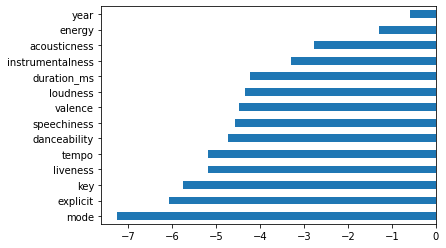

In [ ]:
pre_hyperparameters = dict(max_depth = [5, 11],
                           min_samples_split = [2,10],
                           max_features = [.1, .4],
                           random_state = [42])

tree_reg = DecisionTreeRegressor()

pre_params_tree = pre_modelling(tree_reg, pre_hyperparameters, X_train, y_train)
pre_params_tree 

On constate, pour le modèle `DecisionTreeRegressor` choisi par `RandomizedSearchCV` que *year* est une variable très importante. Cela n'est pas surprenant au vu de la corrélation qu'il y a entre *popularity* et *year*. Ensuite on voit que *energy* est aussi une variable importante. Puis plusieurs variables se talonnent en terme d'importance mais ces dernières ont néanmoins beaucoup moins d'importance que *year* et *energy*. Concernant *key*, *explicit* et *mode* on peut d'ores et déjà avoir en tête qu'on les considèrera peu par la suite. Cependant avant de prendre une décision considérons l'algorithme `RFECV`.

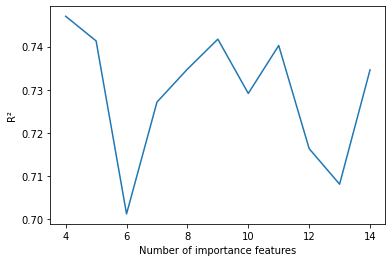

On retient 4  variables.
Ces dernières sont  ['year', 'acousticness', 'duration_ms', 'energy'] .
Le R² moyen sur la cross-validation 0.747 .


In [ ]:
hyperparameters = dict(criterion = ["mse", "friedman_mse", "mae"], 
                       max_depth = [3,5,7,9,11,13], 
                       min_samples_split = [2, 4, 6, 10], 
                       max_features = [.1, .2, .4, .6],
                       random_state = [42])

best_model_tree, features_select_tree = modelling(tree_reg, hyperparameters, X_train, y_train,
          reg=True, select_pre_params = pre_params_tree, n_iter = 15)

On voit sur le plot l'évolution du $R^2$ en fonction du nombre de variables sélectionnées. 

`RandomizedSearchCV` nous renvoie le meilleur modèle qui a pour hyperparamètres :

In [ ]:
best_model_tree.best_params_

{'criterion': 'mse',
 'max_depth': 7,
 'max_features': 0.6,
 'min_samples_split': 10,
 'random_state': 42}

Regardons maintenant quelques indicateurs de performance :

In [ ]:
X_valid2 = features_select_tree.transform(X_valid)
print("Coefficient de détermination de la prédiction : ", 
      round(best_model_tree.score(X_valid2,y_valid),2))
y_pred = best_model_tree.predict(X_valid2)
print("MSE :", round(mean_squared_error(y_valid, y_pred),2))
print("Pourcentage de variance expliquée :", round(explained_variance_score(y_valid, y_pred),2))

Coefficient de détermination de la prédiction :  0.77
MSE : 110.69
Pourcentage de variance expliquée : 0.77


Le $R^2$ et la variance expliquée sont satisfaisants.

#### 2.1.2 Random Forest :

In [ ]:
rfg = RandomForestRegressor()

params_dict = {"n_estimators":[100,200,400],
            "max_depth": [4, 6, 8, 10, 12],
              "max_features": ["auto",0.2],
              "min_samples_split": [10],
              "random_state":[64]
             }

pre_params_dict = {"n_estimators":[100,200],
    "max_depth": [4, 8, 12],
              "max_features": ["auto",0.2],
              "random_state":[64]
             }

{'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 200,
 'random_state': 64}

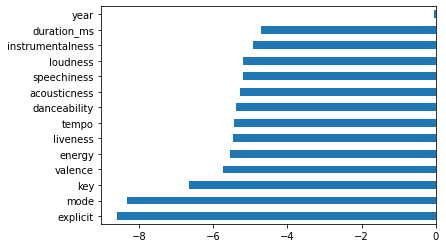

In [ ]:
pre_params_rfg = pre_modelling(rfg, pre_params_dict, X_train, y_train)
pre_params_rfg

Le graphique des importances (échelle log) par feature est très semblable au précédent. La variable *year* est de loin la plus importante, contrairement à *key*, *mode* et *explicit*.

On procède maintenant à la selection par `RFECV` et à l'optimisation finale :

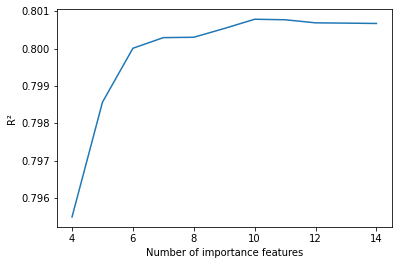

On retient 10  variables.
Ces dernières sont  ['year', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo'] .
Le R² moyen sur la cross-validation 0.801 .


In [ ]:
best_model_rfg, features_select_rfg = modelling(rfg, params_dict, X_train, y_train,
          reg=True, select_pre_params = pre_params_rfg, n_iter = 10)

Voici les meilleurs hyperparamètres obtenus :

In [ ]:
best_model_rfg.best_params_

{'max_depth': 8,
 'max_features': 'auto',
 'min_samples_split': 10,
 'n_estimators': 100,
 'random_state': 64}

In [ ]:
X_valid2 = features_select_rfg.transform(X_valid)
print("Coefficient de détermination de la prédiction : ", 
      round(best_model_rfg.score(X_valid2,y_valid),2))
y_pred = best_model_rfg.predict(X_valid2)
print("MSE :", round(mean_squared_error(y_valid, y_pred),2))
print("Pourcentage de variance expliquée :", round(explained_variance_score(y_valid, y_pred),2))

Coefficient de détermination de la prédiction :  0.79
MSE : 101.26
Pourcentage de variance expliquée : 0.79


On obtient ici aussi des bons résultats.

#### 2.1.3 ExtraTrees :

{'max_depth': 13,
 'max_features': 0.6,
 'min_samples_split': 2,
 'n_estimators': 100}

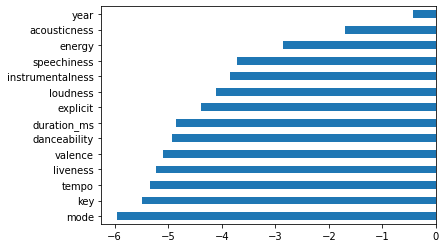

In [ ]:
pre_hyperparameters = dict(n_estimators = [100, 500],
                       max_depth = [5,9,13],
                       min_samples_split = [2,10],
                       max_features = [.2, .6])

extree_reg = ExtraTreesRegressor()

pre_params_extree = pre_modelling(extree_reg, pre_hyperparameters, X_train, y_train)
pre_params_extree

Pour le modèle `ExtraTreesRegressor` choisi par `RandomizedSearchCV`, on constate encore une fois que *year* est une variable très importante. Ici, *acousticness* l'est aussi dans une moindre mesure. Regardons les résultats de `RFECV`.

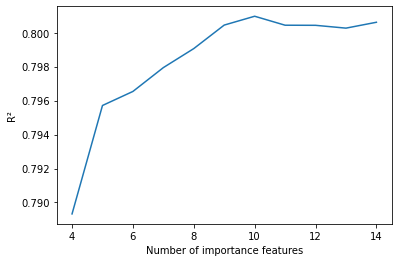

On retient 10  variables.
Ces dernières sont  ['valence', 'year', 'acousticness', 'danceability', 'duration_ms', 'energy', 'explicit', 'instrumentalness', 'loudness', 'speechiness'] .
Le R² moyen sur la cross-validation 0.801 .


In [ ]:
hyperparameters = dict(n_estimators = [100, 300, 500, 1000],
                       criterion =["mse", "mae"],
                       max_depth = [3,5,7,9,11,13],
                       min_samples_split = [2, 4, 6, 10],
                       max_features = [.1, .2, .4, .6])

best_model_extree, features_select_extree = modelling(extree_reg, hyperparameters, X_train, y_train,
          reg=True, select_pre_params = pre_params_extree)


Les hyperparamètres du modèle choisis sont les suivant :

In [ ]:
best_model_extree.best_params_

{'criterion': 'mse',
 'max_depth': 5,
 'max_features': 0.6,
 'min_samples_split': 4,
 'n_estimators': 1000}

Regardons quelques indices de performance :

In [ ]:
X_valid2 = features_select_extree.transform(X_valid)
print("Coefficient de détermination de la prédiction : ", 
      round(best_model_extree.score(X_valid2,y_valid),2))
y_pred = best_model_extree.predict(X_valid2)
print("MSE :", round(mean_squared_error(y_valid, y_pred),2))
print("Pourcentage de variance expliquée :", round(explained_variance_score(y_valid, y_pred),2))

Coefficient de détermination de la prédiction :  0.77
MSE : 109.44
Pourcentage de variance expliquée : 0.77


Ici aussi les indicateurs sont satisfaisants.

#### 2.1.4 Adaboost :

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


{'learning_rate': 0.5, 'n_estimators': 400, 'random_state': 64}

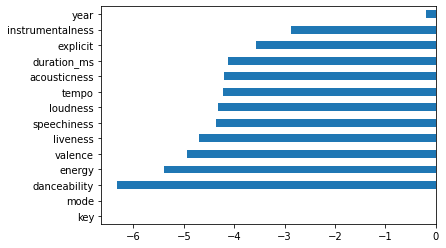

In [ ]:
pre_params_dict = {"n_estimators":[100,200,400],
                   "learning_rate":[0.5,1],
              "random_state":[64]
             }

adaboost_reg = AdaBoostRegressor()

pre_params_adaboostr = pre_modelling(adaboost_reg, pre_params_dict, X_train, y_train)
pre_params_adaboostr

Notez que les variables *mode* et *key* sont vides car suite à la transformation logarithmique, on obtient pour valeur $- \infty$.

On observe toujours que *year* est dominante et *mode* et *key* sont inutiles. Mais il y a tout de même des différences importantes pour les autres variables : par exemple, *danceability* était bien mieux placée avant et inversement *explicit* a étonnamment un bon score ici.

On se réfère à l'algorithme `RFECV` :

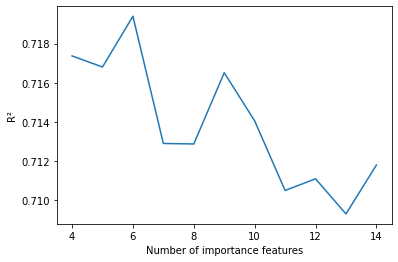

On retient 6  variables.
Ces dernières sont  ['year', 'duration_ms', 'explicit', 'instrumentalness', 'speechiness', 'tempo'] .
Le R² moyen sur la cross-validation 0.719 .


In [ ]:
params_dict = {"n_estimators":[100,200, 400],
                   "learning_rate":[0.2,0.4,0.6,0.8],
              "random_state":[64],
                   "loss":["linear", "square", "exponential"]
             }


best_model_adaboostr, features_select_adaboostr = modelling(adaboost_reg, params_dict, X_train, y_train,
          reg=True, select_pre_params = pre_params_adaboostr, n_iter=10)

In [ ]:
best_model_adaboostr.best_params_

{'learning_rate': 0.2,
 'loss': 'linear',
 'n_estimators': 200,
 'random_state': 64}

In [ ]:
X_valid2 = features_select_adaboostr.transform(X_valid)
print("Coefficient de détermination de la prédiction : ", 
      round(best_model_adaboostr.score(X_valid2,y_valid),2))
y_pred = best_model_adaboostr.predict(X_valid2)
print("MSE :", round(mean_squared_error(y_valid, y_pred),2))
print("Pourcentage de variance expliquée :", round(explained_variance_score(y_valid, y_pred),2))

Coefficient de détermination de la prédiction :  0.71
MSE : 143.19
Pourcentage de variance expliquée : 0.71


On obtient ici encore des résultats satisfaisants.

### 2.2 Support Vector Regression et Kernel Ridge regression :


Dans cette partie, on cherche à évaluer et à comparer les algorithmes `SVR` (Support Vector Regression) et `KRR` (Kernel Ridge Regression) pour la tâche de régression, en testant avec un noyau gaussien d’abord et puis à l’aide de `LinearSVR` (similaire à un SVR à noyau linéaire mais plus performant sur les grandes bases de données). On considère cette comparaison pertinente car les deux algorithmes se basent sur un ”kernel trick”.

#### 2.2.1 SVR avec noyau gaussien :

In [ ]:
svr = SVR()
pre_params_dict_svr={"C": [1e0,1e1],
                 "gamma": np.linspace(0.04, 0.2, 3),
                "kernel":["rbf"],
                "epsilon":[0.1,0.01]}


params_dict_svr = { "C": [1e0, 1e1, 1e2, 1e3],
                 "gamma": np.linspace(0.04, 0.2, 5),
                  "kernel":["rbf"],
               "epsilon":[0.1,0.01,0.001]}

In [ ]:
pre_params_svr = pre_modelling(svr, pre_params_dict_svr, X_train, y_train)

`RFECV` ne pouvant pas être utilisé ici pour faire de la sélection de variables, nous allons utiliser les variables retrouvées par `RandomForestRegressor`.


In [ ]:
var_selected = ['year', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 
                'liveness', 'loudness', 'speechiness', 'tempo']
X_train_reg = X_train[:,np.isin(data.drop(columns=['year','decade'], errors='ignore').columns, var_selected)]
X_valid_reg = X_valid[:,np.isin(data.drop(columns=['year','decade'], errors='ignore').columns, var_selected)]

In [ ]:
best_model_svr, features_select_svr = modelling(svr, params_dict_svr, X_train_reg,
                                                y_train,reg=True, select_pre_params = None)

Voici les paramètres optimaux retrouvés par notre fonction pour ce modèle:

In [ ]:
best_model_svr.best_params_

{'C': 1000.0, 'epsilon': 0.1, 'gamma': 0.04, 'kernel': 'rbf'}

Regardons maintenant quelques indicateurs de performance:


In [ ]:
print("Coefficient de détermination de la prédiction : ", 
      round(best_model_svr.score(X_valid_reg,y_valid),2))
y_pred = best_model_svr.predict(X_valid_reg)
print("MSE :", round(mean_squared_error(y_valid, y_pred),2))
print("Pourcentage de variance expliquée :", round(explained_variance_score(y_valid, y_pred),2))

Coefficient de détermination de la prédiction :  0.76
MSE : 116.58
Pourcentage de variance expliquée : 0.77


On constate que $R^2$ et le pourcentage de variance expliquée sont proches de 1, le modèle est plutôt satisfaisant pour expliquer nos données.


#### 2.2.2 LinearSVR :

In [5]:
linsvr = LinearSVR(max_iter = 4000)

pre_params_dict_linsvr = {"epsilon": [0.0,0.01], #epsilon est la tolerance à l'erreur,i.e si erreurs < eps: ignorés
                 "tol": [1e-4]} 

params_dict_linsvr = {"epsilon": [0.0,0.01,0.001,0.1],
                 "tol": [1e-4,1e-5]} 

In [8]:
par_search_linsvr = GridSearchCV(linsvr, pre_params_dict_linsvr)
fit_parsearch = par_search_linsvr.fit(X_train,y_train)
fit_parsearch.best_params_

{'epsilon': 0.0, 'tol': 0.0001}

Ici, on fait de la séléction de variables à l'aide de `modelling` en utilisant `LinearSVR` comme régresseur.

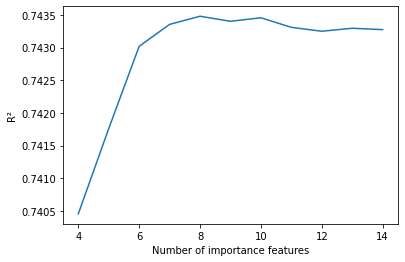

On retient 8  variables.
Ces dernières sont  ['valence', 'year', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness'] .
Le R² moyen sur la cross-validation 0.743 .


In [ ]:
best_model_linsvr, features_select_linsvr = modelling(linsvr, params_dict_linsvr, X_train, y_train,reg=True, select_pre_params = pre_params_linsvr)

Voici les hyperparamètres optimaux trouvés :

In [ ]:
best_model_linsvr.best_params_

{'epsilon': 0.0, 'tol': 0.0001}


Regardons maintenant quelques indicateurs de performance :


In [ ]:
X_valid_linsvr = features_select_linsvr.transform(X_valid)
print("Coefficient de détermination de la prédiction : ", 
      round(best_model_linsvr.score(X_valid_linsvr,y_valid),2))
y_pred = best_model_linsvr.predict(X_valid_linsvr)
print("MSE :", round(mean_squared_error(y_valid, y_pred),2))
print("Pourcentage de variance expliquée :", round(explained_variance_score(y_valid, y_pred),2))

Coefficient de détermination de la prédiction :  0.74
MSE : 125.31
Pourcentage de variance expliquée : 0.75


On constate que $R^2$ et le pourcentage de variance expliquée sont proches de 1, le modèle est plutôt satisfaisant pour expliquer nos données. Les métriques sont plutôt proches des métriques obtenues par SVR avec noyau RBF, on ne constate pas d’amélioration consistante en choisissant un kernel différent.

#### 2.2.3 KRR à noyau gaussien :

In [ ]:
krr = KernelRidge()

pre_params_dict_krr = {"alpha" : [1e0,1e1],
                 "kernel" : ['rbf'],
                 "gamma" : np.linspace(0.04, 0.2, 3)}



In [ ]:
pre_params_krr = pre_modelling(krr, pre_params_dict_krr, X_train, y_train)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
pre_params_krr

{'alpha': 1.0, 'gamma': 0.04, 'kernel': 'rbf'}

Lors du tuning des hyperparamètres, une erreur se produit nous indiquant qu’une tâche n’a pas abouti. Pour des raisons de temps de calcul nous ne sommes pas en mesure d’atteindre l’aboutissement.

In [ ]:
#On ne peut pas utiliser RFECV pour la selection de variables ici. On utilise les features retenues à la section RandomForest

params_dict_krr = {"alpha" : [1e-1,1e0,1e1,1e2],
                 "kernel" : ['rbf'],
                 "gamma" : np.linspace(0.04, 0.2, 4)}


best_model_krr, features_select_krr = modelling(krr, params_dict_krr, X_train_reg, y_train,reg=True, select_pre_params = None)

Voici les hyperparamètres optimaux trouvés pour ce modèle :


In [ ]:
best_model_krr.best_params_

{'alpha': 0.1, 'gamma': 0.14666666666666667, 'kernel': 'rbf'}

Regardons maintenant quelques indicateurs de performance :


In [ ]:
print("Coefficient de détermination de la prédiction : ", 
      round(best_model_krr.score(X_valid_reg,y_valid),2))
y_pred = best_model_krr.predict(X_valid_reg)
print("MSE :", round(mean_squared_error(y_valid, y_pred),2))
print("Pourcentage de variance expliquée :", round(explained_variance_score(y_valid, y_pred),2))

Coefficient de détermination de la prédiction :  0.77
MSE : 111.03
Pourcentage de variance expliquée : 0.77


Encore une fois, on constate que $R^2$ et le pourcentage de variance expliquée sont proches de 1, le modèle est plutôt satisfaisant pour expliquer nos données.
 On observe que les performances de ces trois modèles sont très proches pour nos données, on en conclut donc que les algorithmes SVR et KRR sont plutôt performants et comparables dans ce contexte.


### 2.3 Conclusion sur la régression :

Comparons les résultats obtenus sur le sous-échantillon validation :

In [ ]:
d = dict(R2 = [0.77, 0.79, 0.77, 0.71, 0.76, 0.74, 0.77],
         MSE = [110.69, 101.26, 109.44, 143.19, 116.58, 125.31, 111.03],
         var_ex = [0.77, 0.79, 0.77, 0.71, 0.77, 0.75, 0.77],
         algo = ["Decision Tree", "Random Forest", "Extratrees", "Adaboost", "SVR gaussian", "LinearSVR", "KRR gaussian"])
res = pd.DataFrame(data = d)
res.set_index('algo', inplace = True)
res.sort_values(["MSE"])

,R2,MSE,var_ex
algo,,,
Random Forest,0.79,101.26,0.79
Extratrees,0.77,109.44,0.77
Decision Tree,0.77,110.69,0.77
KRR gaussian,0.77,111.03,0.77
SVR gaussian,0.76,116.58,0.77
LinearSVR,0.74,125.31,0.75
Adaboost,0.71,143.19,0.71


Au vu des performances nous décidons de choisir le modèle Random Forest appliqué au jeu de données avec les variables *year*, *danceability*, *duration_ms*, *energy*, *instrumenalness*, *liveness*, *loudness*, *speechiness* et *tempo* ainsi qu'avec les hyperparamètres suivants (les hyperparamètres non tunnés sont ceux par défaut) :

In [ ]:
best_model_rfg.best_params_

{'max_depth': 8,
 'max_features': 'auto',
 'min_samples_split': 10,
 'n_estimators': 100,
 'random_state': 64}

Et nous obtenons les performances suivantes sur le sous-échantillon test:

In [ ]:
X_test2 = features_select_rfg.transform(X_test)
print("Coefficient de détermination de la prédiction : ", 
      round(best_model_rfg.score(X_test2, y_test),2))
y_pred = best_model_rfg.predict(X_test2)
print("MSE :", round(mean_squared_error(y_test, y_pred),2))
print("Pourcentage de variance expliquée :", round(explained_variance_score(y_test, y_pred),2))

Coefficient de détermination de la prédiction :  0.8
MSE : 95.74
Pourcentage de variance expliquée : 0.8


Le coefficient de détermination est très satisfaisant. On peut dire que ce modèle est bon pour la prédiction de la popularité.

Cependant, il pourrait sûrement être améliorié. En effet, nous sommes limités par la puissance de calcul : on aurait aimé tester des plages d'hyperparamètres plus étendues, avec plus d'itérations dans le `RandomSearchCV` et entrainer nos modèles sur des jeux de données plus grands.
De plus, il existe d'autres types et variantes de modèles de régression, de sélection de variables qui peut-être permettraient d'avoir de meilleurs résultats.


## 3. Tâche de classification :

Pour pouvoir réaliser cette tâche nous allons devoir modifier un peu notre base de données. En effet, nous avons décidé de créer des classes correspondantes aux décennie de 1921 à 2020 soit 11 classes.

Commençons par regarder la répartition des années :

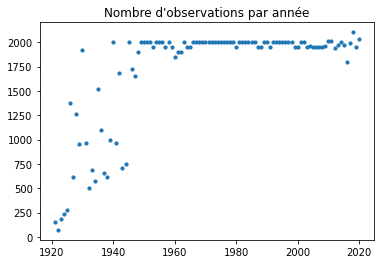

In [13]:
plt.scatter(data['year'].value_counts().index, data['year'].value_counts(), s=10)
plt.title("Nombre d'observations par année")
plt.show()

On constate que la majorité des titres de cette base de données sont sortis entre 1950 et 2020.

On crée une nouvelle variable :

In [ ]:
data['decade']=pd.cut(data.year,bins=[1920,1929,1939,1949,1959,1969,1979,1989,1999,2009,2019,2029],labels=False)

Regardons la répartition des individus dans les différentes classes.

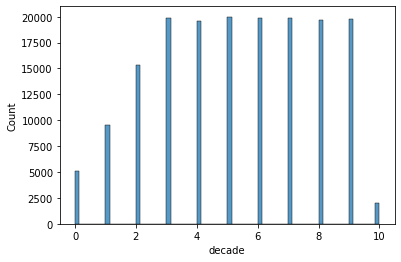

In [ ]:
sns.histplot(data, x='decade')

Nous remarquons que les classes ne sont pas équilibrées. Notamment la décennie 2020 n'est pas assez remplie et dans une moindre mesure c'est aussi le cas des décennies 1920, 1930, 1940. Il existe plusieurs moyens de résoudre ce déséquilibre : on peut balancer notre data set, mettre du poids sur nos classes, restreindre l'échantillon ou encore regarder une problématique de classification un peu différente. Nous choisirons la dernière option car les techniques pour équilibrer les jeux de données seraient hors contexte de l'objectif de ce projet (de plus est ce que notre jeu de données est assez déséquilibré pour justifier l'utilisation de telles méthodes ?) et on ne peut pas intégrer un balancement des classes dans chaque algorithme que nous testons (présence d'un argument class weight non garantis). Ainsi, afin de simplifier notre étude nous nous restreindrons aux décennies comprises entre 1950 et 2010.

In [ ]:
data_y = data[data["decade"].isin(range(3,10))]
data_y["decade"].value_counts()

5    20000
7    19901
6    19850
3    19850
9    19774
8    19646
4    19549
Name: decade, dtype: int64

On obtient bien des classes avec des proportions équivalentes.

Maintenant on va supprimer la variable year car elle ne nous sert plus à rien puis on va séparer notre base de données entre un X (variables explicatives) et un y (variable réponse)

In [ ]:
X = data_y.sample(30000)
y = X['decade']
X = X.drop(columns=['year','decade'])
X = StandardScaler().fit_transform(X) #scale data

On va avoir besoin de séparer notre échantillon en trois partie : Train - Validation - Train avec une séparation 60%-20%-20%

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.4, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
print(X_train.shape,"\n",X_test.shape,"\n",X_valid.shape,"\n",y_train.shape,"\n",y_test.shape,"\n",y_valid.shape)

(18000, 14) 
 (6000, 14) 
 (6000, 14) 
 (18000,) 
 (6000,) 
 (6000,)


Ici, nous rencontrons une difficulté car *LDA*, *QDA*, *KNN* ... n'ont pas de méthode dédiée à la sélection de variables. Alors, après recherche, nous avons opté pour le raisonnement suivant : nous allons d'abord réalisé la classification avec `RandomForestClassifier` puis à l'aide des variables sélectionnées lors de cette étape nous réaliserons les autres algorithmes selon cette sélection.

### 3.1 Random Forest :


Comme pour la plupart des modèles de classification il n'y existe pas de méthode de sélection de variable simple ou évidente, nous allons utiliser la sélection de variables de `RandomForestClassifier` pour déterminer les variables à garder.

In [ ]:
rfc = RandomForestClassifier()

params_dict_rfc = {"n_estimators":[100,200,400],
            "max_depth": [4, 6, 8, 10, 12],
              "max_features": ["auto",0.2],
              "min_samples_split": [10],
              "random_state":[64]
             }

pre_params_dict_rfc = {"n_estimators":[100,200],
    "max_depth": [4, 8, 12],
              "max_features": ["auto",0.2],
              "random_state":[64]
             }

{'max_depth': 12,
 'max_features': 'auto',
 'n_estimators': 200,
 'random_state': 64}

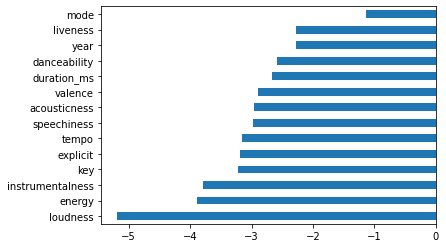

In [ ]:
pre_params_rfc = pre_modelling(rfc, pre_params_dict_rfc, X_train, y_train)
pre_params_rfc

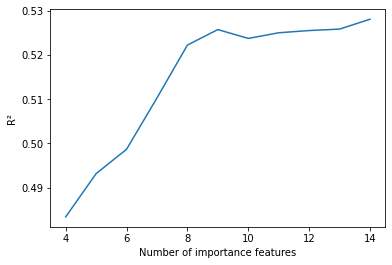

On retient 14  variables.
Ces dernières sont  ['valence', 'acousticness', 'danceability', 'duration_ms', 'energy', 'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo'] .
Le R² moyen sur la cross-validation 0.528 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [ ]:
best_model_rfc, features_select_rfc = modelling(rfc, dict(), # On met un dictionnaire vide car ici le Randomized Search ne nous interesse
                                                             # pas on ne veut que la sélection de variable
                                                # la fonction levera une erreur car pour 1 seul test on préfère GridSearch à RandomizedSearch
                                                X_train, y_train, 
                                                reg = False, select_pre_params = pre_params_rfc)

Ici, nous avons fait le choix de faire un compromis entre la méthode du coude (sur la visualisation des *features_importance*) et l'algorithme `RFECV`. Nous avons décidé d'enlever les 4 variables les moins importantes, soit *loudness*, *instrumentalness*, *energy* et *key* car le gain en $R^2$ pour 14 variables n'est pas très important.

In [ ]:
var_selected = [['valence', 'acousticness', 'danceability', 'duration_ms', 'explicit',
                 'liveness', 'mode', 'popularity', 'speechiness', 'tempo']]
X_train_clf = X_train[:,np.isin(data.drop(columns=['year','decade'], errors='ignore').columns, var_selected)]
X_valid_clf = X_valid[:,np.isin(data.drop(columns=['year','decade'], errors='ignore').columns, var_selected)]
X_test_clf = X_valid[:,np.isin(data.drop(columns=['year','decade'], errors='ignore').columns, var_selected)]

Avec ce choix de variables, voici les hyperparamètres optimaux qui sont retournés :


In [ ]:
best_model_rfc2, features_select_rfc2 = modelling(rfc, params_dict_rfc, X_train_clf, y_train,
                                                      reg=False, select_pre_params = None, n_iter = 10)

In [ ]:
best_model_rfc2.best_params_

{'max_depth': 12,
 'max_features': 'auto',
 'min_samples_split': 10,
 'n_estimators': 200,
 'random_state': 64}

Regardons quelques métriques de performance :

ROC AUC : 0.86
Justesse : 0.5
Matrice de confusion : 



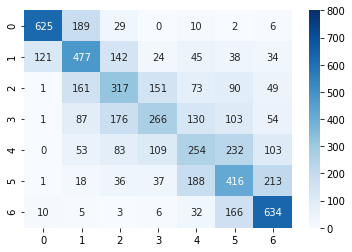

In [ ]:
y_pred = best_model_rfc2.predict(X_valid_clf)
print("ROC AUC :", round(roc_auc_score(y_valid, best_model_rfc2.predict_proba(X_valid_clf), multi_class="ovr"),2))
print("Justesse : "+ str(round(accuracy_score(y_valid, y_pred),2)))
cm = confusion_matrix(y_valid, y_pred)
print("Matrice de confusion : \n")
sns.heatmap(cm, annot=True, vmin=0, vmax=800,cmap='Blues', fmt='g')
plt.show()

Ici on entend par *justesse* la métrique définie par `accuracy_score`, qui pour un sous-ensemble de labels établit si celui-ci correspond exactement au vrai label.

Les métriques sont satisfaisantes, le modèle est plutôt performant dans la tache de classification pour nos données.



### 3.2 Linear/Quadratic Discriminant Analysis :

On teste ensuite `LinearDiscriminantAnalysis` :

In [ ]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_clf,y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

Quelques indicateurs de performance :

ROC AUC : 0.82
Justesse : 0.43
Matrice de confusion : 



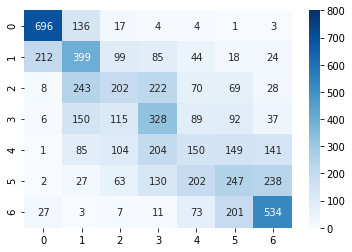

In [ ]:
y_pred = lda.predict(X_valid_clf)
print("ROC AUC :", round(roc_auc_score(y_valid, lda.predict_proba(X_valid_clf), multi_class="ovr"),2))
print("Justesse : "+ str(round(accuracy_score(y_valid, y_pred),2)))
cm = confusion_matrix(y_valid, y_pred)
print("Matrice de confusion : \n")
sns.heatmap(cm, annot=True, vmin=0, vmax=800,cmap='Blues', fmt='g')
plt.show()

La valeur de l'air sous la courbe ROC est satisfaisante. Concernant la justesse ce n'est pas très bon mais au vu de la matrice de confusion nous sommes néamoins assez satisfait : en effet, `LinearDiscriminantAnalysis` a du mal à séparer les décennies qui sont côte à côte mais il ne se trompe pas trop pour des décennies très éloignées (il y a peu de 1950's classées pour des 2010's). Ce n'est pas surprenant qu'il ait du mal à séparer les décennies car nous avions le postulat que les classes seraient mélangées dû au fait que les changements de style de musique ne se font pas avec une coupure nette à chaque décennie. Regardons d'autres algorithmes pour voir si nous pouvons faire mieux en terme de classification.

On teste ensuite `QuadraticDiscriminantAnalysis` :



In [ ]:
qda = QuadraticDiscriminantAnalysis()

hyperparameters = dict(reg_param = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
#Use grid search because we doesn't have that much test to do
clf = GridSearchCV(qda, param_grid=hyperparameters)

#Fit the model
best_model_qda = clf.fit(X_train_clf,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminan

Nous rencontrons un problème au vu des warnings ci dessus. Cependant nous sommes assez étonnées. En effet, `Scikit-Learn` nous indique que nous avons des variables colinéaires. Après quelques tests (non présents sur le notebook pour des raisons de clareté du rapport) nous nous rendons compte que `Scikit-Learn` lève l'erreur lors de la fonction `GridSearchCV` mais que si l'on fait seulement un *QDA* il n'y aura pas d'erreur ... Puis, nous avons aussi regardé à part où est ce que nous avions de la colinéarité. Pour cela nous avons regardé les corrélations entre les variables mais mise à part 2 corrélations fortes il n'y a rien qui nous a sauté aux yeux ... Nous restons sans réponse à ce problème pour le moment. Nous avons décidé de quand même afficher le résultat de *QDA* mais il ne rentrera pas en compte dans le choix de notre modèle final.

In [ ]:
best_model_qda.best_params_

{'reg_param': 0.4}

Regardons les indicateurs de performance :

ROC AUC :  0.8
Justesse :0.4
Matrice de confusion : 



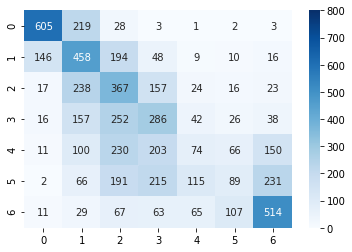

In [ ]:
y_pred = best_model_qda.predict(X_valid_clf)
print("ROC AUC : ", round(roc_auc_score(y_valid, best_model_qda.predict_proba(X_valid_clf), multi_class="ovr"),2))
print("Justesse :" + str(round(accuracy_score(y_valid, y_pred),2)))
cm = confusion_matrix(y_valid, y_pred)
print("Matrice de confusion : \n")
sns.heatmap(cm, annot=True, vmin=0, vmax=800,cmap='Blues', fmt='g')
plt.show()

Les résultats sont un peu moins bon que pour *LDA*. On constate que *QDA* a eu un peu de mal à classer les individus de la décennie 1990's et 2000's.

### 3.2 Regression logistique :


In [ ]:
LR = LogisticRegression()

hyperparameters = {"penalty" : ["l2"],
                   "C" : np.arange(0.4,1.7,0.2),
                    }

best_model_lr, features_select_lr = modelling(LR, hyperparameters, X_train_clf, y_train,
          reg = False, select_pre_params = None, n_iter=7)

In [ ]:
best_model_lr.best_params_

{'C': 1.4000000000000004, 'penalty': 'l2'}

ROC AUC : 0.82
Justesse : 0.44
Matrice de confusion : 



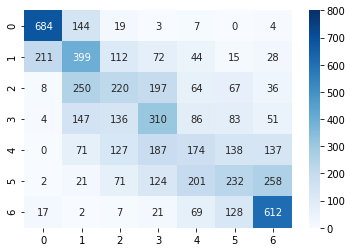

In [ ]:
y_pred = best_model_lr.predict(X_valid_clf)
print("ROC AUC :", round(roc_auc_score(y_valid, best_model_lr.predict_proba(X_valid_clf), multi_class="ovr"),2))
print("Justesse : "+ str(round(accuracy_score(y_valid, y_pred),2)))
cm = confusion_matrix(y_valid, y_pred)
print("Matrice de confusion : \n")
sns.heatmap(cm, annot=True, vmin=0, vmax=800,cmap='Blues', fmt='g')
plt.show()

Les indicateurs de performance sont satisfaisants. On retrouve la même forme diagonale sur la matrice de confusion.



### 3.4 Naives Bayes 


On utilise ici l’algorithme de Naive Bayes, en sachant qu’on attend pas des résultats très satisfaisants car l’algorithme n’est pas performant pour des classes non indépendantes.
D'après plusieurs papiers de recherche, la séléction de variables pour le Naive Bayes peut se faire à l'aides des Decision Trees, on utilise donc les variables retrouvées plus haut 

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train_clf,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

Regardons maintenant quelques indicateurs de performance:


ROC AUC : 0.78
Justesse : 0.34
Matrice de confusion : 



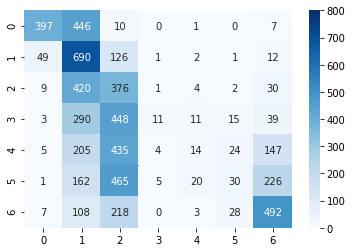

In [ ]:
y_pred = gnb.predict(X_valid_clf)
print("ROC AUC :", round(roc_auc_score(y_valid, gnb.predict_proba(X_valid_clf), multi_class="ovr"),2))
print("Justesse : "+ str(round(accuracy_score(y_valid, y_pred),2)))
cm = confusion_matrix(y_valid, y_pred)
print("Matrice de confusion : \n")
sns.heatmap(cm, annot=True, vmin=0, vmax=800,cmap='Blues', fmt='g')
plt.show()

On confirme donc notre hypothèse concernant la performance de ce modèle pour nos données. Il a totalement ignoré les décennies 1980, 1990 et 2000 et a surchargé les décennies 1960 et 1970.

### 3.5 K nearest neighbors :

In [ ]:
knn = KNeighborsClassifier()

hyperparameters = dict(leaf_size = list(range(10,80,10)), 
                       n_neighbors = list(range(5,22,2)), 
                       p = [1,2])

best_model_knn, features_select_knn = modelling(knn, hyperparameters, X_train_clf, y_train,
          reg = False, select_pre_params = None, n_iter=10)

Les hyperparamètres choisis sont :

In [ ]:
best_model_knn.best_params_

{'leaf_size': 20, 'n_neighbors': 17, 'p': 1}

Regardons les indicateurs :

ROC AUC : 0.82
Justesse :0.45
Matrice de confusion : 



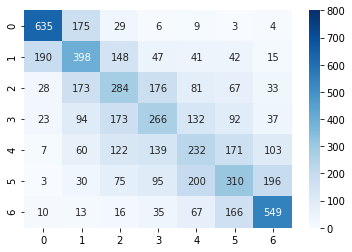

In [ ]:
y_pred = best_model_knn.predict(X_valid_clf)
print("ROC AUC :", round(roc_auc_score(y_valid, best_model_knn.predict_proba(X_valid_clf), multi_class="ovr"),2))
print("Justesse :" + str(round(accuracy_score(y_valid, y_pred),2)))
cm = confusion_matrix(y_valid, y_pred)
print("Matrice de confusion : \n")
sns.heatmap(cm, annot=True, vmin=0, vmax=800,cmap='Blues', fmt='g')
plt.show()

Les résultats sont satisfaisants.

### 3.6 Neural Network :

In [ ]:
MLPc = MLPClassifier()

hyperparameters = {"hidden_layer_sizes" : [(5,10,5),(8,5,5,2),(3,5,2)],
                       "activation" : ["relu","tanh"], 
                       "solver" : ["adam"], 
                       "alpha" : [0.0001,0.001,0.00001], 
                       "batch_size" : [100,200,300],
                       "learning_rate_init" : [0.0001,0.001,0.01], 
                       "random_state" : [64], 
                       "early_stopping" : [True]
                  }

best_model_mplc, features_select_mlpc = modelling(MLPc, hyperparameters, X_train_clf, y_train,
          reg = False, select_pre_params = None, n_iter=15)

In [ ]:
best_model_mplc.best_params_

{'activation': 'tanh',
 'alpha': 0.001,
 'batch_size': 300,
 'early_stopping': True,
 'hidden_layer_sizes': (5, 10, 5),
 'learning_rate_init': 0.01,
 'random_state': 64,
 'solver': 'adam'}

ROC AUC : 0.84
Justesse :0.46
Matrice de confusion : 



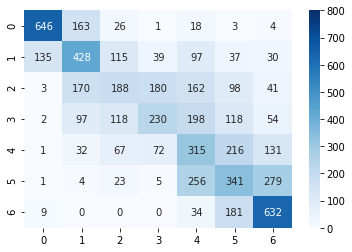

In [ ]:
y_pred = best_model_mplc.predict(X_valid_clf)
print("ROC AUC :", round(roc_auc_score(y_valid, best_model_mplc.predict_proba(X_valid_clf), multi_class="ovr"),2))
print("Justesse :" + str(round(accuracy_score(y_valid, y_pred),2)))
cm = confusion_matrix(y_valid, y_pred)
print("Matrice de confusion : \n")
sns.heatmap(cm, annot=True, vmin=0, vmax=800,cmap='Blues', fmt='g')
plt.show()

Les résultats sont satisfaisants.

### 3.7 Conclusion sur la classification :


Comparons mainenant les performances des algorithmes de classifation précédemment implémentés.

In [ ]:
d = dict(ROC_AUC = [0.88, 0.82, 0.8, 0.82, 0.78, 0.82, 0.84],
         Justesse = [0.53, 0.43, 0.4, 0.44, 0.34, 0.45, 0.46],
         algo = ["Random Forest", "LDA", "QDA", "Logistic Reg", "Naives Bayes", "KNN", "Neural Network"])
res = pd.DataFrame(data = d)
res.set_index('algo', inplace = True)
res.sort_values(["ROC_AUC"], ascending = False)

,ROC_AUC,Justesse
algo,,
Random Forest,0.88,0.53
Neural Network,0.84,0.46
LDA,0.82,0.43
Logistic Reg,0.82,0.44
KNN,0.82,0.45
QDA,0.80,0.40
Naives Bayes,0.78,0.34


Nous choisissons l'algorithme `RandomForestClassifier` car il nous offre de meilleur résultat en terme de AUC et de justesse de prédiction.

Nous appliquons, à l'échantillon test, le modèle `RandomForestClassifier` avec 10 variables *valence*, *acousticness*, *danceability*, *duration_ms*, *explicit*, *liveness*, *mode*, *popularity*, *speechiness* et *tempo* ainsi que les hyperparamètres suivant (les autres sont par défaut) :

In [ ]:
best_model_rfc2.best_params_

{'max_depth': 12,
 'max_features': 'auto',
 'min_samples_split': 10,
 'n_estimators': 200,
 'random_state': 64}

On obtient les résultats suivant :

ROC AUC : 0.88
Justesse : 0.52
Matrice de confusion : 



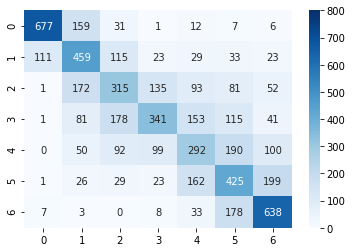

In [ ]:
y_pred = best_model_rfc2.predict(X_test_clf)
print("ROC AUC :", round(roc_auc_score(y_valid, best_model_rfc2.predict_proba(X_test_clf), multi_class="ovr"),2))
print("Justesse : "+ str(round(accuracy_score(y_valid, y_pred),2)))
cm = confusion_matrix(y_valid, y_pred)
print("Matrice de confusion : \n")
sns.heatmap(cm, annot=True, vmin=0, vmax=800,cmap='Blues', fmt='g')
plt.show()

Le ROC AUC est bon mais la justesse de prédiction est moyenne. Celà est dû au fait que les classes se chevauchent beaucoup. On remarque que le modèle classe très bien les chansons qui sont dans les classes extérieures 1950 et 2010 mais qu'il est moins précis au milieu notamment quand il s'agit de distinguer des décennies adjacentes.

Tout comme les limites rencontrées en régression, nous pourrions probablement faire mieux avec une plus grande puissance de calcul (`n_iter` plus grand, échantillon plus grand) et peut-être obtenir de meilleurs résultats avec d'autres méthodes.

La prise en compte d'une expertise métier permettrait de créer des classes plus cohérentes avec l'histoire de l'évolution de la musique au lieu de considérer simplement les décennies.

## Conclusion :

Malgré certaines limites citées ci-dessus, nous sommes satisfaites du modèle de regression. Mais restons un peu sur notre fin quant au modèle de classification sûrement à cause de notre définition des classes peu en accord avec l'évolution de la musique.

A travers ce projet, nous avons pu mettre en œuvre un nombre conséquent d'algorithmes étudiés en cours ainsi que nous familiariser avec des tâches que nous allons rencontrer en entreprise. En découle également une importante montée en compétence en programmation Python avec la manipulation de `sklearn`.